In [1]:
import os
import pandas as pd
import numpy as np
import nltk
import string
import time
import re
import gzip
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import datetime
import pickle
from scipy.stats import randint as sp_randint
from scipy.stats import uniform
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
import json
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
tf.keras.backend.clear_session()
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense,concatenate,Activation,Dropout,Input
from tensorflow.keras.models import Model
import keras
import keras.utils
from tensorflow.keras import utils as np_utils
from tensorflow.keras import models
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import Tokenizer, one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, LSTM, Dropout, BatchNormalization, Dense, concatenate
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau
from keras.utils import plot_model
from IPython.display import Image
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.bleu_score import sentence_bleu
from prettytable import PrettyTable

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Data explorations



In [3]:
#http://jmcauley.ucsd.edu/data/amazon/qa/

def parse(path):
     g = gzip.open(path, 'rb')
     for l in g:
         yield eval(l)

def getDF(path):
     i = 0
     df = {}
     for d in parse(path):
         df[i] = d
         i += 1
     return pd.DataFrame.from_dict(df, orient='index')

In [4]:
%%time
DF1 = getDF('/content/drive/MyDrive/Assignments/Case_study2/qa_Automotive.json.gz')
DF2 = getDF('/content/drive/MyDrive/Assignments/Case_study2/qa_Baby.json.gz')
DF3 = getDF('/content/drive/MyDrive/Assignments/Case_study2/qa_Beauty.json.gz')
DF4 = getDF('/content/drive/MyDrive/Assignments/Case_study2/qa_Cell_Phones_and_Accessories.json.gz')
DF5 = getDF('/content/drive/MyDrive/Assignments/Case_study2/qa_Clothing_Shoes_and_Jewelry.json.gz')
DF6 = getDF('/content/drive/MyDrive/Assignments/Case_study2/qa_Electronics.json.gz')
DF7 = getDF('/content/drive/MyDrive/Assignments/Case_study2/qa_Grocery_and_Gourmet_Food.json.gz')
DF8 = getDF('/content/drive/MyDrive/Assignments/Case_study2/qa_Health_and_Personal_Care.json.gz')
DF9 = getDF('/content/drive/MyDrive/Assignments/Case_study2/qa_Home_and_Kitchen.json.gz')
DF10 = getDF('/content/drive/MyDrive/Assignments/Case_study2/qa_Musical_Instruments.json.gz')
DF11 = getDF('/content/drive/MyDrive/Assignments/Case_study2/qa_Office_Products.json.gz')
DF12 = getDF('/content/drive/MyDrive/Assignments/Case_study2/qa_Patio_Lawn_and_Garden.json.gz')
DF13 = getDF('/content/drive/MyDrive/Assignments/Case_study2/qa_Pet_Supplies.json.gz')
DF14 = getDF('/content/drive/MyDrive/Assignments/Case_study2/qa_Sports_and_Outdoors.json.gz')
DF15 = getDF('/content/drive/MyDrive/Assignments/Case_study2/qa_Tools_and_Home_Improvement.json.gz')
DF16 = getDF('/content/drive/MyDrive/Assignments/Case_study2/qa_Toys_and_Games.json.gz')
DF17 = getDF('/content/drive/MyDrive/Assignments/Case_study2/qa_Video_Games.json.gz')

DF = pd.concat([DF1,DF2,DF3,DF4,DF5,DF6,DF7,DF8,DF9,DF10,DF11,DF12,DF13,DF14,DF15,DF16,DF17],
               sort=False,axis=0)
DF

CPU times: user 44.2 s, sys: 735 ms, total: 44.9 s
Wall time: 46.1 s


,questionType,asin,answerTime,unixTime,question,answer,answerType
0,open-ended,B000022440,"Jan 29, 2013",1.359446e+09,What is the most useful length to get?,at least 20 feet.......heres why....say you ha...,NaN
1,open-ended,B000022440,"Oct 26, 2013",1.382771e+09,Are these cables made of copper or aluminum?,Coleman's website does indeed say copper equiv...,NaN
2,yes/no,B000022440,"Dec 24, 2013",1.387872e+09,I bought the Red Extra Heavy Duty. Is that too...,"For jumper cables, you can never have ""too muc...",?
3,yes/no,B000022440,"Jan 31, 2014",1.391155e+09,"Hi, Being 20ft 4gauge how heavy is this?",Not nearly heavy enough. I keep them under my ...,?
4,yes/no,B000022440,"Dec 1, 2014",1.417421e+09,Do these cables come with a bag?,No,N
...,...,...,...,...,...,...,...
13302,yes/no,B00KGGJPYA,"Nov 26, 2014",1.416989e+09,Does the adaptor cord for the iPhone 5 work wi...,No,N
13303,yes/no,B00KGGJPYA,"Oct 19, 2014",1.413702e+09,will it charge a kidle fire?,"Simply answered, yes. It comes with a 3-in-1 a...",Y
13304,open-ended,B00KGGJPYA,"Oct 15, 2014",1.413356e+09,What are the dimensions of this product?,4 by 1 1/2 inches,NaN
13305,yes/no,B00KGGJPYA,"Jul 15, 2014",1.405408e+09,Does this have connector for 5C? I think 5C is...,I was able to charge Gembonics battery with iP...,?


It could be seen that maximum number of questions contains 2 answers followed by 3 & 4 and there were only few questions that contained single reply.

In [5]:
DF.rename(columns = {'question':'questionText'}, inplace = True)
DF.rename(columns = {'answer':'answerText'}, inplace = True)

In [6]:
data = DF[['questionText','answerText']]

In [7]:
data.shape

(1343851, 2)

Data preprocessing and cleaning

Removal of URL tags

In [8]:
%%time
#https://stackoverflow.com/questions/55422716/how-to-remove-http-url-links-from-a-data-frame-column-in-nlp
def replaceURL(post_title):
    post_title = post_title.map(lambda x: re.sub('((www\.[^\s]+)|(https?://[^\s]+))','',str(x)))
    #post_title = post_title.str.strip()
   # post_title = post_title.map(lambda x: re.sub(r'#([^\s]+)', r'\1','',str(x)))
    return post_title
data['questionText'] = replaceURL(data['questionText'])
data['answerText'] = replaceURL(data['answerText'])

CPU times: user 15.8 s, sys: 69 ms, total: 15.8 s
Wall time: 18.2 s


In [9]:
# https://stackoverflow.com/a/47091490/4084039
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [10]:
preprocessed_questions = []
for sentence in tqdm(data['questionText']):
    sent = decontracted(sentence)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    preprocessed_questions.append(sent.lower().strip())

100%|██████████| 1343851/1343851 [00:20<00:00, 65645.99it/s]


In [11]:
preprocessed_answers = []
for sentence in tqdm(data['answerText']):
    sent = decontracted(sentence)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    preprocessed_answers.append(sent.lower().strip())

100%|██████████| 1343851/1343851 [00:29<00:00, 44911.20it/s]


In [12]:
data['questionText']=preprocessed_questions
data['answerText']=preprocessed_answers

In [13]:
data

,questionText,answerText
0,what is the most useful length to get,at least 20 feet heres why say you have to pul...
1,are these cables made of copper or aluminum,coleman is website does indeed say copper equi...
2,i bought the red extra heavy duty is that too ...,for jumper cables you can never have too much ...
3,hi being 20ft 4gauge how heavy is this,not nearly heavy enough i keep them under my b...
4,do these cables come with a bag,no
...,...,...
13302,does the adaptor cord for the iphone 5 work wi...,no
13303,will it charge a kidle fire,simply answered yes it comes with a 3 in 1 ada...
13304,what are the dimensions of this product,4 by 1 1 2 inches
13305,does this have connector for 5c i think 5c is ...,i was able to charge gembonics battery with ip...


Removing Duplicates

In [14]:
#print("Number of duplicate rows :", data.duplicated().sum())

In [15]:
#data=data.drop_duplicates()

In [16]:
print("Shape of data after removing the duplicate entries :",data.shape)

Shape of data after removing the duplicate entries : (1343851, 2)


In [17]:
data.reset_index(drop=True, inplace=True)

In [18]:
%%time
data["Number of words in Question"] = data["questionText"].str.split().apply(len)

CPU times: user 7.7 s, sys: 707 ms, total: 8.4 s
Wall time: 8.46 s


In [19]:
%%time
data["Number of words in Answer"] = tqdm(data["answerText"].str.split().apply(len))

100%|██████████| 1343851/1343851 [00:00<00:00, 3848557.01it/s]


CPU times: user 9.89 s, sys: 1.45 s, total: 11.3 s
Wall time: 11.4 s


In [20]:
data

,questionText,answerText,Number of words in Question,Number of words in Answer
0,what is the most useful length to get,at least 20 feet heres why say you have to pul...,8,34
1,are these cables made of copper or aluminum,coleman is website does indeed say copper equi...,8,34
2,i bought the red extra heavy duty is that too ...,for jumper cables you can never have too much ...,16,62
3,hi being 20ft 4gauge how heavy is this,not nearly heavy enough i keep them under my b...,8,25
4,do these cables come with a bag,no,7,1
...,...,...,...,...
1343846,does the adaptor cord for the iphone 5 work wi...,no,22,1
1343847,will it charge a kidle fire,simply answered yes it comes with a 3 in 1 ada...,6,17
1343848,what are the dimensions of this product,4 by 1 1 2 inches,7,6
1343849,does this have connector for 5c i think 5c is ...,i was able to charge gembonics battery with ip...,16,22


<Axes: xlabel='Number of words in Question'>

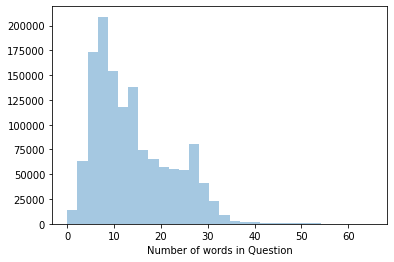

In [21]:
sns.distplot(data["Number of words in Question"],kde=False,bins=30)

It could be seen that maximum number of questions contained approx. 15 to 20 words.

<Axes: xlabel='Number of words in Answer', ylabel='Density'>

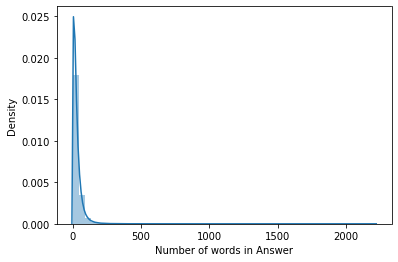

In [22]:
sns.distplot(data["Number of words in Answer"])

It could be seen that maximium number of replies contained only few words.

In [23]:
data = data[data["Number of words in Answer"] <4]

In [24]:
data.shape

(141694, 4)

In [25]:
data.reset_index(drop=True, inplace=True)

In [26]:
data.head()

,questionText,answerText,Number of words in Question,Number of words in Answer
0,do these cables come with a bag,no,7,1
1,do these cables come with a bag,no,7,1
2,do these cables come with a bag,no,7,1
3,will this work on my truck 12 vdc system,yes it will,9,3
4,so i push this once and it is on then i push i...,that is correct,18,3


In [27]:
print("Maximum number of words in a Question:",  data["Number of words in Question"].max())

Maximum number of words in a Question: 56


In [28]:
data['DecoderInput'] = '<sos> ' + data['answerText'].astype(str) + ' <eos>'

Here a <sos> token and <eos> token have been assigned to every answer text.

In [29]:
data.head()

,questionText,answerText,Number of words in Question,Number of words in Answer,DecoderInput
0,do these cables come with a bag,no,7,1,<sos> no <eos>
1,do these cables come with a bag,no,7,1,<sos> no <eos>
2,do these cables come with a bag,no,7,1,<sos> no <eos>
3,will this work on my truck 12 vdc system,yes it will,9,3,<sos> yes it will <eos>
4,so i push this once and it is on then i push i...,that is correct,18,3,<sos> that is correct <eos>


In [30]:
data = data[data["Number of words in Question"] <11] 

In [31]:
data['questionText + answerText'] = data['questionText'] + ' ' + data['DecoderInput']

In [32]:
data

,questionText,answerText,Number of words in Question,Number of words in Answer,DecoderInput,questionText + answerText
0,do these cables come with a bag,no,7,1,<sos> no <eos>,do these cables come with a bag <sos> no <eos>
1,do these cables come with a bag,no,7,1,<sos> no <eos>,do these cables come with a bag <sos> no <eos>
2,do these cables come with a bag,no,7,1,<sos> no <eos>,do these cables come with a bag <sos> no <eos>
3,will this work on my truck 12 vdc system,yes it will,9,3,<sos> yes it will <eos>,will this work on my truck 12 vdc system <sos>...
5,can it be used under 220v for a 20w lamp,sorry no idea,10,3,<sos> sorry no idea <eos>,can it be used under 220v for a 20w lamp <sos>...
...,...,...,...,...,...,...
141685,is this like sims,sure is,4,2,<sos> sure is <eos>,is this like sims <sos> sure is <eos>
141689,is this a hard copy or a download,hard copy,8,2,<sos> hard copy <eos>,is this a hard copy or a download <sos> hard c...
141690,does it play blue ray movies,yes,6,1,<sos> yes <eos>,does it play blue ray movies <sos> yes <eos>
141691,does the kinect less version still play blu ray,yes,9,1,<sos> yes <eos>,does the kinect less version still play blu ra...


In [33]:
data.shape

(89915, 6)

In [34]:
data.to_csv("/content/drive/MyDrive/Assignments/Case_study2/data.csv")

splitting the data

In [35]:
# train test split
encoder_input_train, encoder_input_test, question_answer_train, question_answer_test, decoder_input_train, decoder_input_test = train_test_split(data["questionText"], data["questionText + answerText"], data["DecoderInput"], test_size=0.2)

Here we have done the splitting of data into train-test ratio of 0.8

Converting text into sequesnce vectors

In [36]:
t = Tokenizer(filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n')
t.fit_on_texts(question_answer_train)

encoder_input_train = t.texts_to_sequences(encoder_input_train)
encoder_input_test = t.texts_to_sequences(encoder_input_test)

In [37]:
t.word_index

{'<sos>': 1,
 '<eos>': 2,
 'yes': 3,
 'this': 4,
 'the': 5,
 'is': 6,
 'it': 7,
 'does': 8,
 'a': 9,
 'no': 10,
 'with': 11,
 'will': 12,
 'can': 13,
 'what': 14,
 'work': 15,
 'in': 16,
 'or': 17,
 'fit': 18,
 'have': 19,
 'are': 20,
 'how': 21,
 'for': 22,
 'come': 23,
 'on': 24,
 'of': 25,
 'you': 26,
 'do': 27,
 'these': 28,
 'to': 29,
 'i': 30,
 'made': 31,
 'they': 32,
 'be': 33,
 'many': 34,
 'and': 35,
 'use': 36,
 'size': 37,
 'an': 38,
 'one': 39,
 '2': 40,
 'not': 41,
 'where': 42,
 '1': 43,
 'product': 44,
 'phone': 45,
 'inches': 46,
 '4': 47,
 'china': 48,
 '3': 49,
 'plastic': 50,
 '5': 51,
 'my': 52,
 'there': 53,
 'case': 54,
 'compatible': 55,
 'long': 56,
 '8': 57,
 'used': 58,
 'model': 59,
 'battery': 60,
 'would': 61,
 'about': 62,
 '6': 63,
 'from': 64,
 'color': 65,
 'just': 66,
 'included': 67,
 'black': 68,
 'thanks': 69,
 'only': 70,
 'as': 71,
 'two': 72,
 'camera': 73,
 'good': 74,
 'iphone': 75,
 'charger': 76,
 'batteries': 77,
 '7': 78,
 'include': 79,
 

In [38]:
# saving
with open('tokenizer.pickle', 'wb') as h:
    pickle.dump(t, h, protocol=pickle.HIGHEST_PROTOCOL)

In [39]:
vocab_size = len(t.word_index) + 1
print('Number of unique words in Questions and Answers set: ' ,vocab_size)

Number of unique words in Questions and Answers set:  23881


Let's create 2 dictionaries , one with word-index pair and another with index-word pair so that words and indexes could be traced back.

In [40]:
dicti = t.word_index
word2id = {}
id2word = {}
for k, v in dicti.items():
    word2id[k] = v
    id2word[v] = k

In [41]:
#saving the two dictionaries into a pickled file
with open('word2id.pickle', 'wb') as i:
    pickle.dump(word2id, i, protocol=pickle.HIGHEST_PROTOCOL)
with open('id2word.pickle', 'wb') as j:
    pickle.dump(id2word, j, protocol=pickle.HIGHEST_PROTOCOL)

In [42]:
dicti.items()

dict_items([('<sos>', 1), ('<eos>', 2), ('yes', 3), ('this', 4), ('the', 5), ('is', 6), ('it', 7), ('does', 8), ('a', 9), ('no', 10), ('with', 11), ('will', 12), ('can', 13), ('what', 14), ('work', 15), ('in', 16), ('or', 17), ('fit', 18), ('have', 19), ('are', 20), ('how', 21), ('for', 22), ('come', 23), ('on', 24), ('of', 25), ('you', 26), ('do', 27), ('these', 28), ('to', 29), ('i', 30), ('made', 31), ('they', 32), ('be', 33), ('many', 34), ('and', 35), ('use', 36), ('size', 37), ('an', 38), ('one', 39), ('2', 40), ('not', 41), ('where', 42), ('1', 43), ('product', 44), ('phone', 45), ('inches', 46), ('4', 47), ('china', 48), ('3', 49), ('plastic', 50), ('5', 51), ('my', 52), ('there', 53), ('case', 54), ('compatible', 55), ('long', 56), ('8', 57), ('used', 58), ('model', 59), ('battery', 60), ('would', 61), ('about', 62), ('6', 63), ('from', 64), ('color', 65), ('just', 66), ('included', 67), ('black', 68), ('thanks', 69), ('only', 70), ('as', 71), ('two', 72), ('camera', 73), ('go

In [43]:
# pad documents to a max length of 10 words
max_ques_length = data["Number of words in Question"].max()
encoder_input_train = pad_sequences(encoder_input_train, maxlen=max_ques_length, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=max_ques_length, padding='post')

In [44]:
print(encoder_input_train)
print(encoder_input_test)

[[    8     4  5475 ...     0     0     0]
 [ 2579     5   168 ...     0     0     0]
 [   14    20     5 ...     0     0     0]
 ...
 [    8     4   142 ...     0     0     0]
 [23880     7     6 ...     0     0     0]
 [    6     4     9 ...     0     0     0]]
[[  12   28   15 ... 9806    0    0]
 [   8    7   15 ...    0    0    0]
 [   6    4    9 ... 1989    0    0]
 ...
 [   6    7 1120 ...    0    0    0]
 [   6    4   87 ...    0    0    0]
 [   6    4   55 ...    0    0    0]]


In [45]:
print("Shape of encoder input for train data : ", encoder_input_train.shape)
print("Shape of encoder input for test data : " ,encoder_input_test.shape)

Shape of encoder input for train data :  (71932, 10)
Shape of encoder input for test data :  (17983, 10)


In [46]:
# integer encode the documents
decoder_input_train = t.texts_to_sequences(decoder_input_train)
decoder_input_test = t.texts_to_sequences(decoder_input_test)

In [47]:
# pad documents to a max length of 5 words
max_ans_length = int(data["Number of words in Answer"].max()+2)
decoder_input_train = pad_sequences(decoder_input_train, maxlen=max_ans_length, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=max_ans_length, padding='post')

In [48]:
print(decoder_input_train)
print(decoder_input_test)

[[   1   10    2    0    0]
 [   1   10    2    0    0]
 [   1 1008  180 2580    2]
 ...
 [   1    3    7    8    2]
 [   1   68   68   68    2]
 [   1    3    6   74    2]]
[[   1    3    2    0    0]
 [   1    3    7    8    2]
 [   1 5208 1167    2    0]
 ...
 [   1   10    2    0    0]
 [   1   10    2    0    0]
 [   1 7683    2    0    0]]


In [49]:
print("Shape of decoder input for train data : ", decoder_input_train.shape)
print("Shape of decoder input for test : ", decoder_input_test.shape)

Shape of decoder input for train data :  (71932, 5)
Shape of decoder input for test :  (17983, 5)


In [50]:
# load the whole embedding into memory
embeddings_index = dict()
pickling = open("/content/drive/MyDrive/Assignments/Case_study2/glove_vectors","rb")
glove_words = pickle.load(pickling)

In [51]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in t.word_index.items():
    embedding_vector = glove_words.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [52]:
print(embedding_matrix.shape)

(23881, 300)


In [53]:
embedding_matrix

array([[ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
         0.       ],
       [ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
         0.       ],
       [ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
         0.       ],
       ...,
       [ 0.079576 , -0.33587  ,  0.99122  , ...,  0.19146  , -0.0010444,
         0.41162  ],
       [ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
         0.       ],
       [ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
         0.       ]])

In [54]:
#saving the embedding matrix into a pickle file
with open('embedding_matrix.pickle', 'wb') as l:
    pickle.dump(embedding_matrix, l, protocol=pickle.HIGHEST_PROTOCOL)

Model

In [55]:
BUFFER_SIZE = len(encoder_input_train)
BATCH_SIZE = 64
N_BATCH = BUFFER_SIZE//BATCH_SIZE
embedding_dim = 300
units = 1024

dataset = tf.data.Dataset.from_tensor_slices((encoder_input_train, decoder_input_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [57]:
BUFFER_SIZE_val = len(encoder_input_test)
BATCH_SIZE_val = 64
N_BATCH_val = BUFFER_SIZE_val//BATCH_SIZE_val

dataset_val = tf.data.Dataset.from_tensor_slices((encoder_input_test, decoder_input_test)).shuffle(BUFFER_SIZE_val)
dataset_val = dataset_val.batch(BATCH_SIZE_val, drop_remainder=True)

In [58]:
def gru(units):
    return tf.keras.layers.GRU(units, return_sequences=True,return_state=True, recurrent_activation='sigmoid',recurrent_initializer='glorot_uniform')

class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_ques_length, 
                                                   weights=[embedding_matrix], trainable=False)
        self.gru = gru(self.enc_units)
    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)        
        return output, state
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_ans_length, 
                                                   weights=[embedding_matrix], trainable=False)
        self.gru = gru(self.dec_units)
        self.fc = tf.keras.layers.Dense(vocab_size)
        # used for attention
        self.W1 = tf.keras.layers.Dense(self.dec_units)
        self.W2 = tf.keras.layers.Dense(self.dec_units)
        self.V = tf.keras.layers.Dense(1)
    def call(self, x, hidden, enc_output):
        # we are doing this to perform addition to calculate the score
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        # this is to compute scores s1, s2, ...
        score = self.V(tf.nn.tanh(self.W1(enc_output) + self.W2(hidden_with_time_axis)))
        # this is the step to compute attention weights e1, e2, ...
        attention_weights = tf.nn.softmax(score, axis=1)
        # this is to compute the context_vector = e1*h1 + e2*h2 + ...
        context_vector = attention_weights * enc_output
        context_vector = tf.reduce_sum(context_vector, axis=1)
        x = self.embedding(x)
        # this is the step to concatenate the context vector with the output of the previous time step
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        # passing the concatenated vector to the GRU
        output, state = self.gru(x)
        # output shape == (batch_size * 1, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))
        # output shape == (batch_size * 1, vocab)
        # this is the step to compute the next output word in the sequence
        x = self.fc(output)
        # return current output, current state and the attention weights
        return x, state, attention_weights
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.dec_units))
      
# Create objects of Class Encoder and Class Decoder
encoder = Encoder(vocab_size, embedding_dim, units, BATCH_SIZE)
decoder = Decoder(vocab_size, embedding_dim, units, BATCH_SIZE)

In [59]:
optimizer = tf.optimizers.SGD()
import keras.backend as K
def loss_function(real, pred):
    mask = 1 - np.equal(real, 0)
    loss_ = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=real, logits=pred) * mask
    return tf.reduce_mean(loss_)


def accuracy_fn(y_true, y_pred):
    # y_pred shape is batch_size, seq length, vocab size
    # y_true shape is batch_size, seq length
    pred_values = K.cast(K.argmax(y_pred, axis=-1), dtype='int32')
    correct = K.cast(K.equal(y_true, pred_values), dtype='float32')

    # 0 is padding, don't include those
    mask = K.cast(K.greater(y_true, 0), dtype='float32')
    n_correct = K.sum(mask * correct)
    n_total = K.sum(mask)
  
    return n_correct / n_total
    
checkpoint_dir = '/content/drive/My Drive/Multiple Response/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,encoder=encoder,decoder=decoder)

In [60]:
# https://www.tensorflow.org/tensorboard/get_started
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = 'logs/gradient_tape/' + current_time + '/train'
test_log_dir = 'logs/gradient_tape/' + current_time + '/test'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
test_summary_writer = tf.summary.create_file_writer(test_log_dir)

In [61]:
from sklearn.metrics import roc_auc_score

In [63]:
#https://betterprogramming.pub/a-guide-on-the-encoder-decoder-model-and-the-attention-mechanism-401c836e2cdb
%%time
EPOCHS = 20
loss_list=[]
acc_list = []
loss_list_val=[]
acc_list_val = []
for epoch in range(EPOCHS):
    start = time.time()
    hidden = encoder.initialize_hidden_state()
    total_loss = 0
    total_acc = 0
    for (batch, (inp, targ)) in enumerate(dataset):
        loss = 0
        acc = 0
        with tf.GradientTape() as tape:
            enc_output, enc_hidden = encoder(inp, hidden)
            dec_hidden = enc_hidden
            dec_input = tf.expand_dims([word2id['<sos>']] * BATCH_SIZE, 1)   
            # Teacher forcing - feeding the target as the next input
            for t in range(1, targ.shape[1]):
                # passing enc_output to the decoder
                predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
                loss += loss_function(targ[:, t], predictions)
                acc+= accuracy_fn(targ[:, t], predictions)
                # using teacher forcing
                dec_input = tf.expand_dims(targ[:, t], 1)
        batch_loss = (loss / int(targ.shape[1]))
        total_loss += batch_loss
        batch_acc = (acc / int(targ.shape[1]))
        total_acc += batch_acc
        variables = encoder.variables + decoder.variables
        gradients = tape.gradient(loss, variables)
        optimizer.apply_gradients(zip(gradients, variables))
        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f} Acc {:.4f}'.format(epoch + 1,batch,batch_loss.numpy(), batch_acc.numpy()))
    # saving (checkpoint) the model every epoch
    checkpoint.save(file_prefix = checkpoint_prefix)
    with train_summary_writer.as_default():
         tf.summary.scalar('loss', total_loss, step=EPOCHS)
    print('Epoch {} Loss {:.4f} Acc{:.4f}'.format(epoch + 1,total_loss / N_BATCH, total_acc/N_BATCH ))
    loss_list.append(total_loss / N_BATCH)
    acc_list.append(total_acc / N_BATCH)



    hidden_val = encoder.initialize_hidden_state()
    total_loss_val = 0
    total_acc_val = 0
    for (batch_val, (inp_val, targ_val)) in enumerate(dataset_val):
        loss_val = 0
        acc_val = 0
        enc_output_val, enc_hidden_val = encoder(inp_val, hidden_val)
        dec_hidden_val = enc_hidden_val
        dec_input_val = tf.expand_dims([word2id['<sos>']] * BATCH_SIZE_val, 1)       
        for t in range(1, targ_val.shape[1]):
            predictions_val, dec_hidden_val, _ = decoder(dec_input_val, dec_hidden_val, enc_output_val)
            loss_val += loss_function(targ_val[:, t], predictions_val)
            acc_val+= accuracy_fn(targ[:, t], predictions)
            dec_input_val = tf.expand_dims(targ_val[:, t], 1)
        batch_loss_val = (loss_val / int(targ_val.shape[1]))
        total_loss_val += batch_loss_val
        batch_acc_val = (acc_val / int(targ_val.shape[1]))
        total_acc_val += batch_acc_val
        
        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss_val {:.4f}  Acc_val {:.4f}'.format(epoch + 1,batch_val,batch_loss_val.numpy(), batch_acc_val.numpy()))
    print('Epoch {} Loss_val {:.4f} Acc_val {:.4f}' .format(epoch + 1,total_loss_val / N_BATCH_val, total_acc_val/N_BATCH_val))
    loss_list_val.append(total_loss_val / N_BATCH_val)
    acc_list_val.append(total_acc_val/N_BATCH_val)
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    with test_summary_writer.as_default():
         tf.summary.scalar('loss', total_loss_val, step=EPOCHS)

   

Epoch 1 Batch 0 Loss 5.4179 Acc 0.0000
Epoch 1 Batch 100 Loss 2.8800 Acc 0.4240
Epoch 1 Batch 200 Loss 2.4942 Acc 0.4656
Epoch 1 Batch 300 Loss 2.3518 Acc 0.4355
Epoch 1 Batch 400 Loss 1.5479 Acc 0.4935
Epoch 1 Batch 500 Loss 1.7146 Acc 0.4896
Epoch 1 Batch 600 Loss 2.0557 Acc 0.4073
Epoch 1 Batch 700 Loss 2.2436 Acc 0.4163
Epoch 1 Batch 800 Loss 1.7828 Acc 0.4837
Epoch 1 Batch 900 Loss 1.8428 Acc 0.4500
Epoch 1 Batch 1000 Loss 1.9046 Acc 0.4577
Epoch 1 Batch 1100 Loss 2.2553 Acc 0.4215
Epoch 1 Loss 2.1318 Acc0.4533
Epoch 1 Loss_val 1.6614 Acc_val 0.2364
Time taken for 1 epoch 223.5434877872467 sec

Epoch 2 Batch 0 Loss 1.3997 Acc 0.4946
Epoch 2 Batch 100 Loss 2.3117 Acc 0.4210
Epoch 2 Batch 200 Loss 1.3677 Acc 0.5362
Epoch 2 Batch 300 Loss 2.0035 Acc 0.5003
Epoch 2 Batch 400 Loss 1.6413 Acc 0.4828
Epoch 2 Batch 500 Loss 1.5563 Acc 0.4638
Epoch 2 Batch 600 Loss 1.8401 Acc 0.4826
Epoch 2 Batch 700 Loss 1.3805 Acc 0.5100
Epoch 2 Batch 800 Loss 1.6804 Acc 0.4890
Epoch 2 Batch 900 Loss 1.7

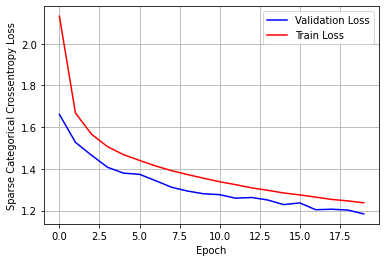

In [64]:
def plt_dynamic(x, vy, ty, ax, colors=['b']):
    ax.plot(x, vy, 'b', label="Validation Loss")
    ax.plot(x, ty, 'r', label="Train Loss")
    plt.legend()
    plt.grid()
    fig.canvas.draw()
    
fig,ax = plt.subplots(1,1)
ax.set_xlabel('Epoch') ; ax.set_ylabel('Sparse Categorical Crossentropy Loss')
epochs=list(range(EPOCHS))
plt_dynamic(epochs, loss_list_val, loss_list, ax)

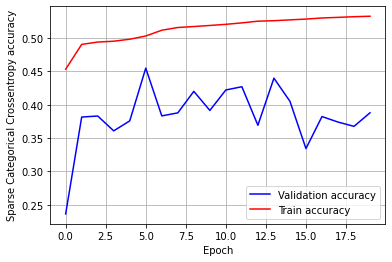

In [65]:
def plt_dynamic(x, vy, ty, ax, colors=['b']):
    ax.plot(x, vy, 'b', label="Validation accuracy")
    ax.plot(x, ty, 'r', label="Train accuracy")
    plt.legend()
    plt.grid()
    fig.canvas.draw()
    
fig,ax = plt.subplots(1,1)
ax.set_xlabel('Epoch') ; ax.set_ylabel('Sparse Categorical Crossentropy accuracy')
epochs=list(range(EPOCHS))
plt_dynamic(epochs, acc_list_val, acc_list, ax)

We could see here that loss has gradually decreased and accuracy got improved from initial state however for validation accuracy we could see more fluctuations which can be eliminated by feature engineering or adding more data points.

INFERENCE  SET-UP

In [66]:
def evaluate(inputs, encoder, decoder, max_length_inp, max_length_targ):
    attention_plot = np.zeros((max_ans_length,max_ques_length ))
    sentence = ''
    for i in inputs[0]:
        if i == 0:
            break
        sentence = sentence + id2word[i] + ' '
    inputs = tf.convert_to_tensor(inputs)
    result = ''
    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)
    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([word2id['<sos>']], 0)
    for t in range(max_length_targ): # limit the length of the decoded sequence
        predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_out)
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()
        predicted_id = tf.argmax(predictions[0]).numpy()
        result += id2word[predicted_id] + ' '
        if id2word[predicted_id] == '<eos>':
            return result, sentence, attention_plot
        dec_input = tf.expand_dims([predicted_id], 0)
    return result, sentence, attention_plot

In [79]:
def predict_random_quesans():
    actual_sent = ''
    k = np.random.randint(len(encoder_input_test))
    random_input = encoder_input_test[k]
    random_output = decoder_input_test[k]
    random_input = np.expand_dims(random_input,0)
    result, sentence, attention_plot = evaluate(random_input, encoder, decoder, max_ques_length, max_ans_length)
    print('Question: {}'.format(sentence))
    print('Predicted answer: {}'.format(result))
    for i in random_output:
        if i == 0:
            break
        actual_sent = actual_sent + id2word[i] + ' '
    actual_sent = actual_sent
    print('Actual answer: {}'.format(actual_sent))
    attention_plot = attention_plot[:len(result.split(' '))-2, 1:len(sentence.split(' '))-1]
    sentence, result = sentence.split(' '), result.split(' ')
    sentence = sentence[1:-1]
    result = result[:-2]
    # trace = go.Heatmap(z = attention_plot, x = sentence, y = result, colorscale='Reds')
    # data=[trace]
    # iplot(data)
predict_random_quesans()

Question: is the container free 
Predicted answer: yes <eos> 
Actual answer: <sos> yes <eos> 


In [73]:
predict_random_quesans()

Question: will this fit a 2008 a frontier 6 bed 
Predicted answer: yes <eos> 
Actual answer: <sos> yes <eos> 


In [71]:
predict_random_quesans()

Question: does this order come with a mattress 
Predicted answer: yes <eos> 
Actual answer: <sos> nope <eos> 


In [80]:
predict_random_quesans()

Question: does have a 3 ply steamer 
Predicted answer: yes <eos> 
Actual answer: <sos> yes <eos> 


In [81]:
predict_random_quesans()

Question: what is the diameter of this table 
Predicted answer: about 4 inches <eos> 
Actual answer: <sos> 38 inches <eos> 


In [84]:
predict_random_quesans()

Question: how many btus does the unit give off 
Predicted answer: 2 <eos> 
Actual answer: <sos> 34 000 btu <eos> 


In [85]:
predict_random_quesans()

Question: is it ok for d300s 
Predicted answer: yes <eos> 
Actual answer: <sos> yes <eos> 


Performance measurement:

In [86]:
def predict_corpus(dataset_input,dataset_output):
    actual_sent = ''
    k = len(dataset_input)
    predicted_answer_list=[]
    actual_answer_list=[]
    for j in tqdm(range(k)):
        random_input = dataset_input[j]
        random_output = dataset_output[j]
        random_input = np.expand_dims(random_input,0)
        result, sentence, attention_plot = evaluate(random_input, encoder, decoder, max_ques_length, max_ans_length)
        for i in random_output:
            if i == 0:
               break
            actual_sent = actual_sent + id2word[i] + ' '
        actual_sent = actual_sent
        sentence, result = sentence.split(' '), result.split(' ')
        sentence = sentence
        result = result
        predicted_answer_list.append(result)
        actual_answer_list.append(actual_sent)
    return predicted_answer_list,actual_answer_list

In [87]:
%%time
predicted_answer_list,actual_answer_list = predict_corpus(encoder_input_test,decoder_input_test)

100%|██████████| 17983/17983 [11:39<00:00, 25.70it/s]

CPU times: user 11min 24s, sys: 9.76 s, total: 11min 34s
Wall time: 11min 39s


In [91]:
bleu_score_test = corpus_bleu(predicted_answer_list, actual_answer_list)
print("Bleu score on test dataset:",bleu_score_test)

Bleu score on test dataset: 0.2120112485190492
